# 24 - PCA analysis

ANOVA - Analysis of variance

## Import libraries

In [13]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

## Config notebook

In [2]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False
# How to save?
if_exists='append'
# save to local?
save_local = False
# use local data?
local_data = False
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [3]:
# 'alex' or 'edgar'
all_local_dirs = 'edgar'
# Output hexs resolution
res = 10
# Persona speed
walk_speed = 4.5
speed_name = str(walk_speed).replace('.','_')

In [4]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

## __Load data__

### __Load data__ - Pois proximity (regular and unique ID pois)

In [5]:
if local_data:
    hex_gdf = gpd.read_file(grl_dir + f'santiago_hexanalysis_{speed_name}_kmh_res{res}.gpkg')
else:
    query = f'SELECT * FROM projects_research.santiago_hexanalysis_{speed_name}_kmh WHERE res = {res}'
    hex_gdf = aup.gdf_from_query(query)

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(58695, 31)


,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,sociability_caring,sociability_living,...,hex_id,geometry,supplying,caring,living,enjoying,learning,working,hqsl,res
0,5.833333,5.833333,5.0,5.638199,7.5,4.166667,33.971533,4.583333,1.875,0.543189,...,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",5.87963,5.25712,3.59773,4.894993,5.833333,4.943534,30.406339,10


### __Load data__ - Comunas

In [6]:
# From notebook 12-Areal-data-to-hex.ipynb
if all_local_dirs == 'alex':
    comuna_gdf = gpd.read_file(grl_dir + 'santiago_comunas.geojson')
elif all_local_dirs == 'edgar':
    comuna_gdf = gpd.read_file(grl_dir + 'santiago_comunas.geojson')

# Show
comuna_gdf = comuna_gdf.explode()
comuna_gdf['area_ha'] = comuna_gdf.to_crs("EPSG:32719").area/10000
comuna_gdf = comuna_gdf[['Comuna','area_ha','geometry']]
comuna_gdf = comuna_gdf.rename(columns={'Comuna':'Nombre'})
comuna_gdf = comuna_gdf.reset_index(drop=True)
print(comuna_gdf.shape)
comuna_gdf.head(1)

(36, 3)


,Nombre,area_ha,geometry
0,San Joaquín,987.687671,"POLYGON ((-70.62342 -33.47338, -70.62292 -33.4..."


### __Load data__ - Buffer Alameda

In [7]:
# From notebook 12-Areal-data-to-hex.ipynb
if all_local_dirs == 'alex':
    alameda_gdf = gpd.read_file(grl_dir + 'unidades_vecinales_buffer800m_alameda_v2.gpkg')
elif all_local_dirs == 'edgar':
    alameda_gdf = gpd.read_file(grl_dir + 'unidades_vecinales_buffer800m_alameda_v2.gpkg')

# Show
alameda_gdf = alameda_gdf.dissolve()
alameda_gdf['area_ha'] = alameda_gdf.to_crs("EPSG:32719").area/10000
alameda_gdf['Nombre'] = 'Nueva Alameda'
alameda_gdf = alameda_gdf[['Nombre','area_ha','geometry']]
print(alameda_gdf.shape)
alameda_gdf.head(1)

(1, 3)


,Nombre,area_ha,geometry
0,Nueva Alameda,2266.840098,"POLYGON ((-70.71634 -33.46959, -70.71651 -33.4..."


## PCA

### Data by area of analysis

In [48]:
nombre_comuna = ['Las Condes','Pedro Aguirre Cerda',
                'Quinta Normal','San Miguel',
                'Maipú','Conchalí','El Bosque',
                'Providencia']
comuna_analysis = comuna_gdf.loc[comuna_gdf.Nombre.isin(nombre_comuna)].copy()
comparison_gdf = pd.concat([comuna_analysis,alameda_gdf])
comparison_gdf

,Nombre,area_ha,geometry
1,San Miguel,963.502832,"POLYGON ((-70.63659 -33.51873, -70.63740 -33.5..."
6,Providencia,1439.652277,"POLYGON ((-70.58484 -33.43126, -70.58445 -33.4..."
17,Conchalí,1098.672380,"POLYGON ((-70.66314 -33.39923, -70.66400 -33.3..."
18,El Bosque,1426.967489,"POLYGON ((-70.66324 -33.58516, -70.66340 -33.5..."
23,Las Condes,9839.607402,"POLYGON ((-70.53235 -33.38217, -70.53235 -33.3..."
28,Maipú,13803.803111,"POLYGON ((-70.76505 -33.45926, -70.76505 -33.4..."
30,Pedro Aguirre Cerda,850.130544,"POLYGON ((-70.67123 -33.51069, -70.67179 -33.5..."
33,Quinta Normal,1186.605299,"POLYGON ((-70.70527 -33.40762, -70.70463 -33.4..."
0,Nueva Alameda,2266.840098,"POLYGON ((-70.71634 -33.46959, -70.71651 -33.4..."


### Spatial intersection

In [49]:
hex_analysis = hex_gdf.merge(hex_gdf.sjoin(comparison_gdf)[['hex_id','Nombre']], on='hex_id',
                             how='right')
print(hex_analysis.shape)
hex_analysis.head(4)

(15694, 32)


,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,sociability_caring,sociability_living,...,geometry,supplying,caring,living,enjoying,learning,working,hqsl,res,Nombre
0,5.833333,5.833333,5.000000,5.638199,7.500000,4.166667,33.971533,4.583333,1.875000,0.543189,...,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",5.879630,5.257120,3.597730,4.894993,5.833333,4.943534,30.406339,10,Nueva Alameda
1,2.845833,2.532738,2.836364,4.570114,1.393876,3.750000,17.928926,3.202652,3.052083,0.134702,...,"POLYGON ((-70.54047 -33.41159, -70.54110 -33.4...",3.512286,3.050925,2.731769,5.760304,1.046366,2.500000,18.601651,10,Las Condes
2,0.729167,1.497396,0.000000,2.500000,2.173611,3.333333,10.233507,1.250000,4.479167,0.116598,...,"POLYGON ((-70.69534 -33.46458, -70.69597 -33.4...",0.914352,2.983119,0.969422,2.403274,1.890432,1.732263,10.892862,10,Nueva Alameda
3,1.250000,3.080357,4.250000,0.406806,3.952381,4.166667,17.106211,2.678571,5.000000,0.543317,...,"POLYGON ((-70.67531 -33.57591, -70.67594 -33.5...",2.248677,3.723022,3.653328,2.227213,3.141534,2.916667,17.910441,10,El Bosque


### Select specific location

In [109]:
sitio_analysis = 'Nueva Alameda'

In [110]:
col_analysis = ['Nombre','sociability','wellbeing','environmental_impact',
                  'supplying','caring','living',
                  'enjoying','working','learning',
                  'hqsl']

hex_pca = hex_analysis.loc[hex_analysis.Nombre==sitio_analysis,col_analysis].copy()
print(hex_pca.shape)
hex_pca.head(1)

(1931, 11)


,Nombre,sociability,wellbeing,environmental_impact,supplying,caring,living,enjoying,working,learning,hqsl
0,Nueva Alameda,17.198441,33.971533,32.917721,5.87963,5.25712,3.59773,4.894993,4.943534,5.833333,30.406339


### Data transformation

In [111]:
X = np.array(hex_pca.drop(columns='Nombre'))
y = hex_pca.Nombre
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)  

### PCA

In [112]:
pca = PCA()
x_new = pca.fit_transform(X)

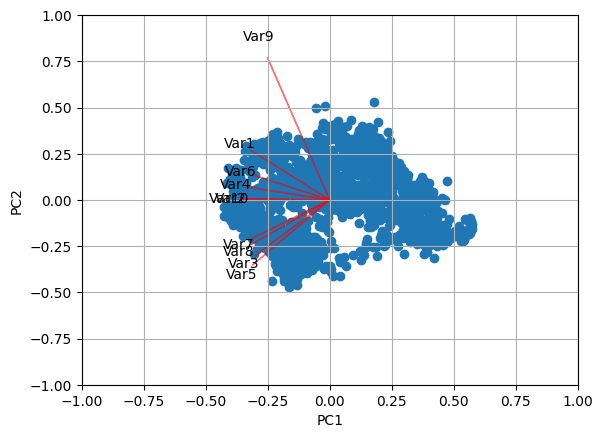

In [113]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [114]:
np.set_printoptions(suppress=True)
pca.explained_variance_ratio_

array([0.80135914, 0.07288856, 0.04028129, 0.02478421, 0.0197337 ,
       0.01776121, 0.01327474, 0.00968051, 0.00023664, 0.        ])

In [115]:
col_analysis = ['sociability','wellbeing','environmental_impact',
                  'supplying','caring','living',
                  'enjoying','working','learning',
                  'hqsl']

In [116]:
print(abs( pca.components_ ))

[[0.31427484 0.34558462 0.30013076 0.33121189 0.30852356 0.31014769
  0.31992543 0.31844389 0.25000569 0.35267944]
 [0.26521096 0.00434671 0.3007347  0.06981045 0.34970996 0.13526065
  0.21266511 0.24305636 0.76773043 0.00490299]
 [0.12329966 0.20480981 0.57406039 0.21884813 0.00610046 0.57265413
  0.18111827 0.43841875 0.08887427 0.06728199]
 [0.46371238 0.03989351 0.3164268  0.00600399 0.51764131 0.34007668
  0.24482834 0.17678384 0.45628363 0.01498309]
 [0.38612327 0.09875834 0.29885054 0.21486318 0.49511457 0.0736239
  0.63670943 0.05389954 0.21611075 0.01053303]
 [0.58614237 0.27167822 0.04271201 0.4263694  0.27521309 0.4074749
  0.35355929 0.13587123 0.10694095 0.04830441]
 [0.23048303 0.25954578 0.52330239 0.37671928 0.38484155 0.40405335
  0.26123223 0.27955523 0.00510451 0.0772603 ]
 [0.04597689 0.0210694  0.05696273 0.62412011 0.03540082 0.16761788
  0.27622046 0.68064869 0.18847738 0.01478063]
 [0.22972184 0.828036   0.14691088 0.20450511 0.12555571 0.2194204
  0.2142566  0.

<AxesSubplot: >

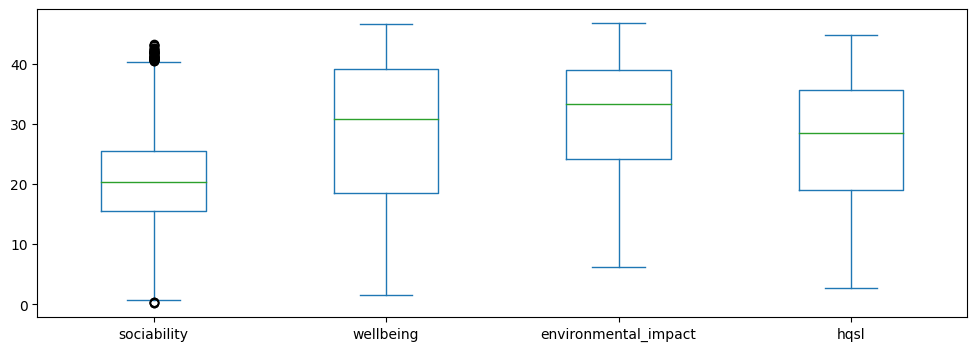

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
hex_plot = hex_pca.drop(columns='Nombre').copy()
hex_plot[['sociability','wellbeing','environmental_impact','hqsl']].plot(kind='box', ax=ax)

<AxesSubplot: >

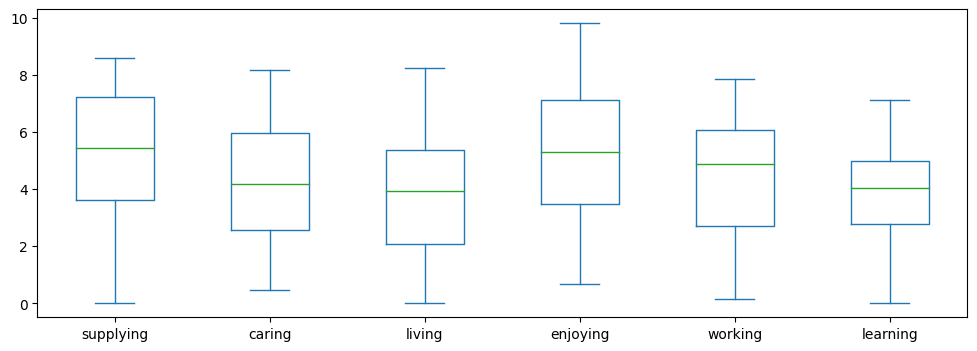

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
hex_plot = hex_pca.drop(columns='Nombre').copy()
hex_plot[['supplying','caring','living',
                  'enjoying','working','learning']].plot(kind='box', ax=ax)